In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.naive_bayes import BernoulliNB

In [2]:
# use the yelp file for training, change target to bool
file = 'data/yelp_labelled.txt'
df = pd.read_csv(file, sep='\t',header=None)
df.columns = ['review', 'target']
df['length'] = pd.Series([len(string) for string in df.review.str.strip()])
df.target = np.where(df.target,True, False)
df.head()

,review,target,length
0,Wow... Loved this place.,True,24
1,Crust is not good.,False,18
2,Not tasty and the texture was just nasty.,False,41
3,Stopped by during the late May bank holiday of...,True,87
4,The selection on the menu was great and so wer...,True,59


Checked if string length could be feature but populations are nearly identical

In [8]:
df.groupby('target').length.describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
False,500.0,60.750,34.224935,11.0,33.00,52.5,84.00,149.0
True,500.0,55.882,30.228390,11.0,32.75,49.5,73.25,148.0


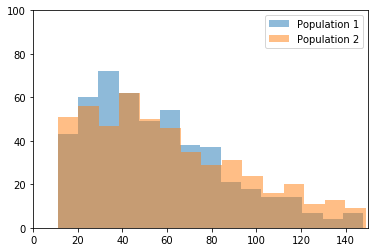

In [10]:
    nbins = 15
    plt.axis([0, 150, 0, 100])
    plt.hist(df.length[df.target == True],  bins=nbins, alpha=0.5, label='Population 1')
    plt.hist(df.length[df.target == False], bins=nbins, alpha=0.5, label='Population 2')
    plt.legend(loc='upper right')
    plt.show()

In [6]:
# clean and split review strings 

def A(df): return df.apply(lambda x: x.str.strip(), axis=1) 
def B(df): return df.apply(lambda x: x.str.replace(r"\Bn't\b", ' not ', regex=True), axis=1)
def C(df): return df.apply(lambda x: x.str.replace(r'\W+', ' ', regex=True), axis=1)
def D(df): return df.apply(lambda x: x.str.replace(r'\d+', ' ', regex=True), axis=1)
def E(df): return df.apply(lambda x: x.str.lower(), axis=1) 
def F(df): return df.apply(lambda x: x.str.replace(r"\bnot\s", 'not', regex=True), axis=1)
def G(df): return df.apply(lambda x: x.str.replace(r'\s{2}', ' ', regex=True), axis=1)  
def H(df): return df.apply(lambda x: x.str.strip(), axis=1)
def I(df): return df.apply(lambda x: x.str.split(), axis=1)

switch = {char:eval(char) for char in 'ABCDEFGHI'}

def switch_clean_df(df, string):
    for char in string:
        df = switch[char](df)
    return df 

In [7]:
# create cleaned list of reviews as lists for target = true, target = false, all reviews
crt = switch_clean_df(pd.DataFrame(df.review[df.target]),          'ABCDEGHI').review
crf = switch_clean_df(pd.DataFrame(df.review[df.target == False]), 'ABCDEGHI').review
cra = switch_clean_df(pd.DataFrame(df.review),                     'ABCDEGHI').review
# create list of "all words for target = true, target = false, all reviews
awt = [t for rt in crt for t in rt]
awf = [f for rf in crf for f in rf]
awa = [a for ra in cra for a in ra]
# create list of words that are only in target = true, target = false
owt = list(set(awt) - set(awf))
owf = list(set(awf) - set(awt))
# counters of all words that are only in target = true, target = false, all reviews
ctt = Counter(); ctf = Counter(); cta = Counter()
ctt.update([t for t in awt if t in owt]) 
ctf.update([f for f in awf if f in owf]) 
cta.update([a for a in awa])

In [11]:
#kwt = [val for val, count in ctt.most_common(10) if count >= 10]
#kwf = [val for val, count in ctf if count >= 10]
kwa = [x for x in cta if cta[x] >= len(df) // 100]

In [13]:
dfa = pd.DataFrame({key:np.where(df.review.str.contains(key), True, False) for key in kwa})
#dff = pd.DataFrame({key:np.where(df.review.str.contains(key), False, True) for key in kwf})
dfa.head(2)

,loved,this,place,is,not,good,tasty,and,the,was,...,flavor,probably,can,wo,pizza,from,recommend,terrible,perfect,awesome
0,False,True,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,True,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [14]:
df1 = pd.concat([df, dfa], axis = 1)
df1 = df1.drop(axis=1,columns='review')
df1.head(2)

,target,length,loved,this,place,is,not,good,tasty,and,...,flavor,probably,can,wo,pizza,from,recommend,terrible,perfect,awesome
0,True,24,False,True,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,18,False,False,False,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [17]:
target = df1['target']
data = df1.drop(columns=['target'], axis=1)

In [18]:
# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()
# Fit our model to the data.
bnb.fit(data, target)
# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)
# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 239


In [21]:
bnb.fit(data, target).score(data, target)

0.761